In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

In [13]:
df = pd.read_csv("customer_complaint_escalation_textual.csv")
df.head()

,complaint_text,sentiment_score,complaint_channel,product,customer_tier,past_complaints,resolution_attempts,complaint_length,escalated
0,No response from support team,0.59,Social Media,Insurance,Basic,0,3,5,0
1,Delivery was delayed and no proper explanation...,-0.04,Social Media,Insurance,Gold,1,2,9,0
2,The service quality is extremely poor,-0.77,Chat,Mobile App,Silver,2,1,6,1
3,No response from support team,-0.75,Social Media,Insurance,Basic,2,4,5,0
4,The issue has not been resolved despite multip...,0.37,Chat,Internet Service,Platinum,5,4,9,1


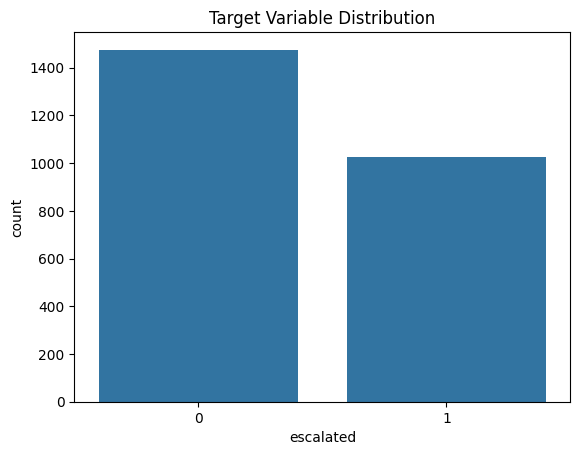

In [14]:
sns.countplot(x="escalated", data=df)
plt.title("Target Variable Distribution")
plt.show()

In [15]:
le = LabelEncoder()

for col in ["complaint_channel", "product", "customer_tier"]:
    df[col] = le.fit_transform(df[col])

df = df.drop(columns=["complaint_text"])

In [16]:
X = df.drop("escalated", axis=1)
y = df["escalated"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
models = {
    "Logistic Regression": (
        LogisticRegression(max_iter=1000),
        {"C": [0.1, 1, 10]}
    ),
    "Decision Tree": (
        DecisionTreeClassifier(random_state=42),
        {"max_depth": [5, 10, 15]}
    ),
    "Random Forest": (
        RandomForestClassifier(random_state=42),
        {"n_estimators": [200], "max_depth": [10, 15]}
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=42),
        {"n_estimators": [150], "learning_rate": [0.05, 0.1]}
    ),
    "SVM": (
        SVC(probability=True),
        {"C": [1, 10]}
    )
}

In [18]:
results = []
best_model = None
best_f1 = 0

for name, (model, params) in models.items():
    grid = GridSearchCV(model, params, cv=5, scoring="f1", n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = grid.best_estimator_.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append([name, acc, prec, rec, f1])

    if f1 > best_f1:
        best_f1 = f1
        best_model = grid.best_estimator_

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])
results_df_sorted = results_df.sort_values(by="F1 Score", ascending=False)
results_df_sorted

,Model,Accuracy,Precision,Recall,F1 Score
3,Gradient Boosting,0.832,0.810256,0.770732,0.790000
0,Logistic Regression,0.828,0.793103,0.785366,0.789216
4,SVM,0.830,0.803030,0.775610,0.789082
1,Decision Tree,0.814,0.788660,0.746341,0.766917
2,Random Forest,0.804,0.774359,0.736585,0.755000


BEST MODEL SELECTED: Gradient Boosting

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       295
           1       0.81      0.77      0.79       205

    accuracy                           0.83       500
   macro avg       0.83      0.82      0.82       500
weighted avg       0.83      0.83      0.83       500

Final Accuracy: 83.20%


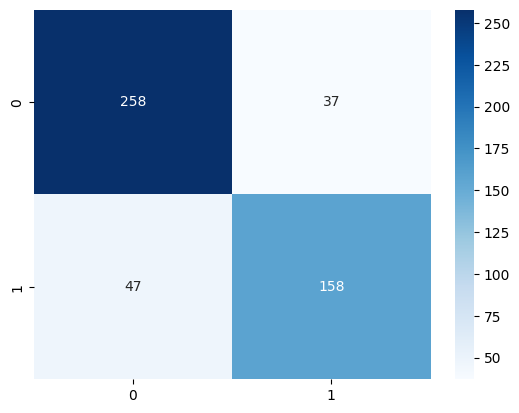

In [19]:
best_model_name = results_df_sorted.iloc[0]["Model"]

y_pred_best = best_model.predict(X_test)

print(f"BEST MODEL SELECTED: {best_model_name}\n")
print(classification_report(y_test, y_pred_best))

final_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Final Accuracy: {final_accuracy * 100:.2f}%")

cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

In [20]:
import joblib

joblib.dump(best_model, "new_best_escalation_model.pkl")
joblib.dump(scaler, "escalation_scaler.pkl")

print("Model and scaler saved successfully")

Model and scaler saved successfully
